In [2]:
import sys
sys.path.append("../")

In [3]:
from glob import glob
from monai.data import Dataset, DataLoader
from monai.data.box_utils import convert_box_mode
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    CropForegroundd,
    Spacingd,
    ForegroundMask
)
import os.path
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import torch
import itk
import tempfile
import math


In [4]:
def save_nifti_from_array(img_array, output_dir,  filename):
    filename = os.path.join(output_dir, f"{filename}.nii.gz")
    itk_np_view = itk.image_view_from_array(img_array)
    itk.imwrite(itk_np_view, filename)

In [5]:
min_abdomen_size_mm = (125, 125, 320)  # in mm
def get_min_sized_abdomen(orig_size_pix, img_pix_dim, boxes_pix: torch.Tensor):
    """
    Returns the bounding box of the minimum sized abdomen in pixels.
    Extracts the physical size of the abdomen from the given bounding box.
    If the abdomen is too small, expands the bounding box to the minimum size, 
    else does not change the bounding box.
    This function does not change the original resolution of the image.
    """
    print(img_pix_dim, "Old box",  boxes_pix)
    img_size_mm = img_pix_dim * orig_size_pix
    boxes_mm = torch.concat((boxes_pix[:3] * img_pix_dim, boxes_pix[3:] * img_pix_dim))

    xcenter, ycenter, zcenter, xsize, ysize, zsize = convert_box_mode(
        boxes_mm.unsqueeze(0), src_mode="xyzxyz", dst_mode="cccwhd"
    ).squeeze(0)
    xsize_min, ysize_min, zsize_min = np.maximum(min_abdomen_size_mm, (xsize, ysize, zsize))
    xmin, ymin, zmin, xmax, ymax, zmax = convert_box_mode(
        torch.tensor([[xcenter, ycenter, zcenter, xsize_min, ysize_min, zsize_min]]),
        src_mode="cccwhd",
        dst_mode="xyzxyz",
    ).squeeze(0).numpy()

    # convert back to pixel coordinates
    x1 = math.floor(max(0, boxes_pix[0] - abs(xmin)) / img_pix_dim[0])
    y1 = math.floor(max(0, boxes_pix[1] - abs(ymin)) / img_pix_dim[1])
    z1 = math.floor(max(0, boxes_pix[2] - abs(zmin)) / img_pix_dim[2])
    x2 = math.floor(xmax / img_pix_dim[0])
    y2 = math.floor(ymax / img_pix_dim[1])
    z2 = math.floor(zmax / img_pix_dim[2])

    print("New box: ", x1, y1, z1, x2, y2, z2)
    return x1, y1, z1, x2, y2, z2

In [6]:
supervised_dir = "/mnt/HDD2/flare2022/datasets/FLARE2022/Training/FLARE22_LabeledCase50"
def get_paths(path: str):
    paths = glob(os.path.join(supervised_dir, path, "*.nii.gz"))
    paths.sort()
    return paths

In [7]:
image_paths = get_paths("images")
label_paths = get_paths("labels")

data_dicts = tuple(
    {"image": img, "label": lab} for img, lab in zip(image_paths, label_paths)
)


In [8]:
coarse_roi_size = (128, 128, 64)
fine_roi_size = (192, 192, 96)
intermediate_roi_size = (256, 256, 128)
coarse_scale = np.asarray(intermediate_roi_size) / np.asarray(coarse_roi_size)
inverse_coarse_scale = tuple(1 / coarse_scale)

output_dir = "~/coarse_resized_data"
gpu_index = -1
sw_batch_size = 2
sw_overlap = 0.25
num_workers = 4

coarse_ckpt_path = "../coarse_boundingmask_semi.ts"

keys = ("image", "label")


# Explore Abdomen Sizes in different images

In [113]:
transforms = Compose(
        (
            LoadImaged(reader="NibabelReader", keys=keys),
            EnsureChannelFirstd(keys=keys),
            CustomResized(keys=keys, roi_size=coarse_roi_size),
            Orientationd(keys=keys, axcodes="RAI"),
            HistogramNormalized(keys="image", min=-1, max=1),
            ToTensord(keys=keys),
        )
    )

dataset = Dataset(data_dicts, transforms)

saver = NiftiSaver(
    output_dir,
    output_dtype=np.uint8,
    dtype=np.float32,
    mode="nearest",
    padding_mode="zeros",
    separate_folder=False,
    channel_dim=0,
    print_log=True,  # make false for docker
)

device = torch.device("cpu" if gpu_index < 0 else f"cuda:{gpu_index}")

coarse_sliding_inferer = SlidingWindowInferer(
    coarse_roi_size,
    sw_batch_size,
    sw_overlap,
    mode="gaussian",
    cache_roi_weight_map=True,
)

# resize_fine = CustomResize(roi_size=fine_roi_size, image_only=True)

keep_connected_component_coarse = KeepLargestConnectedComponent(
            independent=False,
            connectivity=None,
        )

crop_foreground = CropForegroundd(keys=keys, source_key="label")
foreground_mask = ForegroundMask()

dl = DataLoader(
    dataset,
    batch_size=1,  # Because the images do not align and are not cropped
    num_workers=num_workers,
)

def get_label_volume(arr, pix_dim):
    arr = np.count_nonzero(arr)
    return arr * pix_dim[0] * pix_dim[1] * pix_dim[2]

In [114]:
# keys = ("image", "label")
# transforms = Compose(
#     (
#         LoadImaged(reader="NibabelReader", keys=keys),
#         EnsureChannelFirstd(keys=keys),
#         Orientationd(keys, axcodes="RAI"),
#         # CropForegroundd(keys=keys, source_key="label"),
#         # Spacingd(keys="image", pixdim=(1, 1, 1)),
#     )
# )

In [115]:
# num_workers = 4
# dataset = Dataset(data_dicts, transforms)
# dl = DataLoader(
#     dataset,
#     batch_size=2,
#     num_workers=num_workers,
# )

In [150]:
spatial_size = 3
image_sizes = np.empty((len(dl), spatial_size), dtype=np.uint16)
pix_dims = np.empty((len(dl), spatial_size), dtype=np.float16)
label_vol_orig = np.empty((len(dl)), dtype=np.float32)
label_vol_cropped = np.empty((len(dl)), dtype=np.float32)
label_vol_resized = np.empty((len(dl)), dtype=np.float32)

# from monai.transforms.utils import generate_spatial_bounding_box
for i, batch in enumerate(tqdm(dl)):
    img_filename = batch["image_meta_dict"]['filename_or_obj'][0].split('/')[-1].split('.')[0]
    label_filename = batch["label_meta_dict"]['filename_or_obj'][0].split('/')[-1].split('.')[0]

    print(img_filename)
    pix_dims[i] = np.abs(np.diag(batch['image_meta_dict']['affine'][0])[:-1])
    image_sizes[i] = batch["image"].shape[-spatial_size:] * pix_dims[i]
    label_vol_orig[i] = get_label_volume(batch["label"][0], pix_dims[i])
    print("Image size in mm:", image_sizes[i], " Pix dim:", pix_dims[i], " Label vol:", label_vol_orig[i])

    # mask = foreground_mask(batch["image"])
    # crop_image = crop_foreground({"image": batch['image'], "label": mask})
    # save_nifti_from_array(crop_image, f"{i}_from_mask")

    # start_dim, end_dim = generate_spatial_bounding_box(batch["image"])
    # print(start_dim, end_dim)
    # _, x1, y1, z1 = start_dim
    # _, x2, y2, z2 = end_dim
    # print("Bounding box in pix:", x1, y1, z1, x2, y2, z2)
    # x1, y1, z1, x2, y2, z2 = get_min_sized_abdomen(image_sizes[i], pix_dim, torch.tensor((x1, y1, z1, x2, y2, z2)))
    # print("Bounding box in pix after resize:", x1, y1, z1, x2, y2, z2)

  8%|▊         | 4/50 [00:02<00:19,  2.34it/s]

FLARE22_Tr_0001_0000
Image size in mm: [330 330 275]  Pix dim: [1.289 1.289 2.148]  Label vol: 3049896.8
FLARE22_Tr_0002_0000
Image size in mm: [380 380 267]  Pix dim: [1.484 1.484 2.09 ]  Label vol: 3753164.5
FLARE22_Tr_0003_0000
Image size in mm: [393 393 252]  Pix dim: [1.535 1.535 1.973]  Label vol: 2933875.5
FLARE22_Tr_0004_0000
Image size in mm: [375 375 217]  Pix dim: [1.465 1.465 1.699]  Label vol: 2900706.2


 12%|█▏        | 6/50 [00:03<00:23,  1.89it/s]

FLARE22_Tr_0005_0000
Image size in mm: [396 396 212]  Pix dim: [1.547 1.547 1.66 ]  Label vol: 2906294.5
FLARE22_Tr_0006_0000
Image size in mm: [442 442 232]  Pix dim: [1.727 1.727 1.816]  Label vol: 3360994.0
FLARE22_Tr_0007_0000
Image size in mm: [407 407 262]  Pix dim: [1.59 1.59 2.05]  Label vol: 4140359.0
FLARE22_Tr_0008_0000
Image size in mm: [400 400 247]  Pix dim: [1.5625 1.5625 1.934 ]  Label vol: 3630652.8


 18%|█▊        | 9/50 [00:04<00:20,  2.02it/s]

FLARE22_Tr_0009_0000
Image size in mm: [413 413 217]  Pix dim: [1.613 1.613 1.699]  Label vol: 3036181.5
FLARE22_Tr_0010_0000
Image size in mm: [420 420 240]  Pix dim: [1.641 1.641 1.875]  Label vol: 3218221.2
FLARE22_Tr_0011_0000
Image size in mm: [392 392 210]  Pix dim: [1.531 1.531 1.641]  Label vol: 3092598.5
FLARE22_Tr_0012_0000
Image size in mm: [421 421 257]  Pix dim: [1.645 1.645 2.012]  Label vol: 3252469.5


 26%|██▌       | 13/50 [00:06<00:15,  2.32it/s]

FLARE22_Tr_0013_0000
Image size in mm: [398 398 227]  Pix dim: [1.555 1.555 1.777]  Label vol: 2944923.2
FLARE22_Tr_0014_0000
Image size in mm: [418 418 177]  Pix dim: [1.633 1.633 1.387]  Label vol: 2955349.5
FLARE22_Tr_0015_0000
Image size in mm: [370 370 210]  Pix dim: [1.445 1.445 1.641]  Label vol: 4209781.5
FLARE22_Tr_0016_0000
Image size in mm: [385 385 232]  Pix dim: [1.504 1.504 1.816]  Label vol: 2697273.5


 34%|███▍      | 17/50 [00:07<00:13,  2.42it/s]

FLARE22_Tr_0017_0000
Image size in mm: [474 474 270]  Pix dim: [1.852 1.852 2.11 ]  Label vol: 3869775.8
FLARE22_Tr_0018_0000
Image size in mm: [420 420 245]  Pix dim: [1.641 1.641 1.914]  Label vol: 3796865.0
FLARE22_Tr_0019_0000
Image size in mm: [386 386 490]  Pix dim: [1.508 1.508 3.828]  Label vol: 4461026.5
FLARE22_Tr_0020_0000
Image size in mm: [406 406 230]  Pix dim: [1.586 1.586 1.797]  Label vol: 3827118.2


 42%|████▏     | 21/50 [00:09<00:11,  2.52it/s]

FLARE22_Tr_0021_0000
Image size in mm: [460 460 250]  Pix dim: [1.797 1.797 1.953]  Label vol: 2844348.2
FLARE22_Tr_0022_0000
Image size in mm: [394 394 490]  Pix dim: [1.539 1.539 3.828]  Label vol: 3267992.0
FLARE22_Tr_0023_0000
Image size in mm: [400 400 255]  Pix dim: [1.5625 1.5625 1.992 ]  Label vol: 2760891.8
FLARE22_Tr_0024_0000
Image size in mm: [408 408 247]  Pix dim: [1.594 1.594 1.934]  Label vol: 3441430.2


 52%|█████▏    | 26/50 [00:10<00:08,  2.85it/s]

FLARE22_Tr_0025_0000
Image size in mm: [460 460 212]  Pix dim: [1.797 1.797 1.66 ]  Label vol: 2422573.8
FLARE22_Tr_0026_0000
Image size in mm: [350 350 416]  Pix dim: [1.367 1.367 3.25 ]  Label vol: 2266194.8
FLARE22_Tr_0027_0000
Image size in mm: [477 477 255]  Pix dim: [1.863 1.863 1.992]  Label vol: 3468726.8
FLARE22_Tr_0028_0000
Image size in mm: [500 500 222]  Pix dim: [1.953 1.953 1.738]  Label vol: 4205941.0


 60%|██████    | 30/50 [00:12<00:07,  2.85it/s]

FLARE22_Tr_0029_0000
Image size in mm: [405 405 232]  Pix dim: [1.582 1.582 1.816]  Label vol: 2814067.2
FLARE22_Tr_0030_0000
Image size in mm: [409 409 247]  Pix dim: [1.598 1.598 1.934]  Label vol: 2825307.2
FLARE22_Tr_0031_0000
Image size in mm: [446 446 252]  Pix dim: [1.742 1.742 1.973]  Label vol: 3267975.0
FLARE22_Tr_0032_0000
Image size in mm: [465 465 257]  Pix dim: [1.816 1.816 2.012]  Label vol: 3064095.8


 68%|██████▊   | 34/50 [00:13<00:05,  2.90it/s]

FLARE22_Tr_0033_0000
Image size in mm: [460 460 267]  Pix dim: [1.797 1.797 2.09 ]  Label vol: 2986725.5
FLARE22_Tr_0034_0000
Image size in mm: [394 394 235]  Pix dim: [1.539 1.539 1.836]  Label vol: 2781150.8
FLARE22_Tr_0035_0000
Image size in mm: [500 500 252]  Pix dim: [1.953 1.953 1.973]  Label vol: 3589729.5
FLARE22_Tr_0036_0000
Image size in mm: [396 396 222]  Pix dim: [1.547 1.547 1.738]  Label vol: 2471551.8


 74%|███████▍  | 37/50 [00:15<00:04,  2.61it/s]

FLARE22_Tr_0037_0000
Image size in mm: [374 374 197]  Pix dim: [1.461 1.461 1.543]  Label vol: 3364015.0


 76%|███████▌  | 38/50 [00:15<00:04,  2.77it/s]

FLARE22_Tr_0038_0000
Image size in mm: [429 429 272]  Pix dim: [1.676 1.676 2.129]  Label vol: 3870836.2
FLARE22_Tr_0039_0000
Image size in mm: [451 451 250]  Pix dim: [1.762 1.762 1.953]  Label vol: 3774145.0
FLARE22_Tr_0040_0000
Image size in mm: [393 393 232]  Pix dim: [1.535 1.535 1.816]  Label vol: 3070052.0


 82%|████████▏ | 41/50 [00:16<00:03,  2.65it/s]

FLARE22_Tr_0041_0000
Image size in mm: [399 399 245]  Pix dim: [1.559 1.559 1.914]  Label vol: 2747814.5


 84%|████████▍ | 42/50 [00:16<00:02,  2.80it/s]

FLARE22_Tr_0042_0000
Image size in mm: [428 428 232]  Pix dim: [1.672 1.672 1.816]  Label vol: 3232397.5
FLARE22_Tr_0043_0000
Image size in mm: [444 444 212]  Pix dim: [1.734 1.734 1.66 ]  Label vol: 2719832.2
FLARE22_Tr_0044_0000
Image size in mm: [485 485 207]  Pix dim: [1.895 1.895 1.621]  Label vol: 4196430.5


 92%|█████████▏| 46/50 [00:18<00:01,  2.80it/s]

FLARE22_Tr_0045_0000
Image size in mm: [500 500 282]  Pix dim: [1.953 1.953 2.207]  Label vol: 4385227.0
FLARE22_Tr_0046_0000
Image size in mm: [370 370 232]  Pix dim: [1.445 1.445 1.816]  Label vol: 2247100.5
FLARE22_Tr_0047_0000
Image size in mm: [493 493 282]  Pix dim: [1.926 1.926 2.207]  Label vol: 3216708.0
FLARE22_Tr_0048_0000
Image size in mm: [399 399 237]  Pix dim: [1.559 1.559 1.855]  Label vol: 4424049.5


 98%|█████████▊| 49/50 [00:19<00:00,  2.68it/s]

FLARE22_Tr_0049_0000
Image size in mm: [392 392 217]  Pix dim: [1.531 1.531 1.699]  Label vol: 2678221.2


100%|██████████| 50/50 [00:19<00:00,  2.52it/s]

FLARE22_Tr_0050_0000
Image size in mm: [420 420 237]  Pix dim: [1.641 1.641 1.855]  Label vol: 3899678.2


In [151]:
labels = ("Frontal (X) Axis", "Sagittal (Y) Axis", "Longitudinal (Z) Axis")

![CT Scan Axes](ct_scan_axes.png)

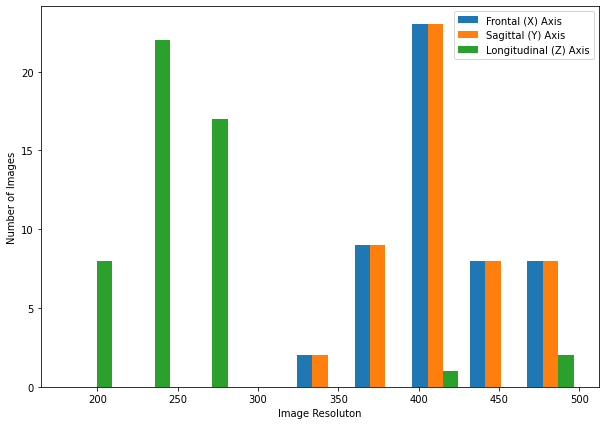

In [152]:
plt.figure(figsize=(10, 7))
plt.hist(image_sizes, bins="auto", label=labels)
plt.xlabel("Image Resoluton")
plt.ylabel("Number of Images")
plt.legend();

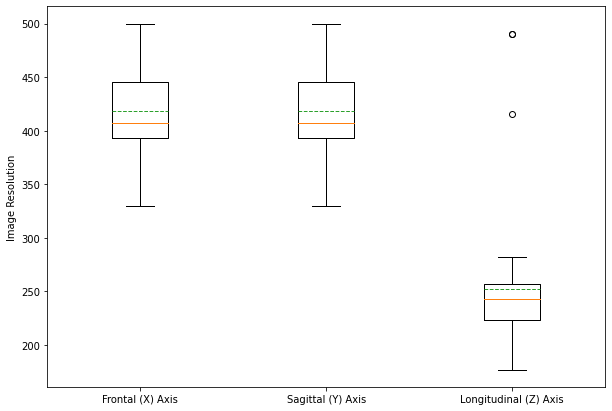

In [153]:
plt.figure(figsize=(10, 7))
plt.boxplot(
    image_sizes,
    showmeans=True,
    meanline=True,
    labels=labels,
)
plt.ylabel("Image Resolution");


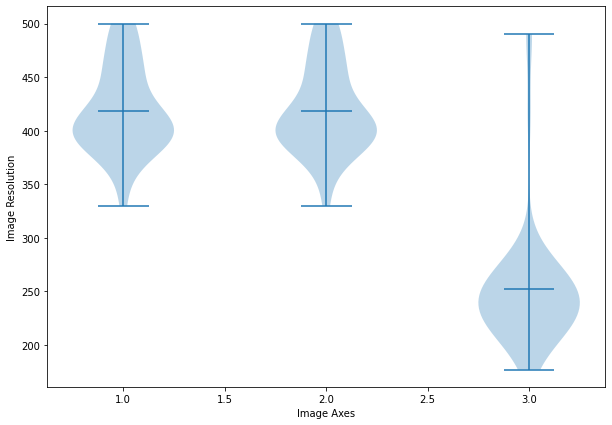

In [154]:
plt.figure(figsize=(10, 7))
plt.violinplot(image_sizes, showmeans=True)
plt.xlabel("Image Axes")
plt.ylabel("Image Resolution");

In [155]:
image_volumes = label_vol_orig

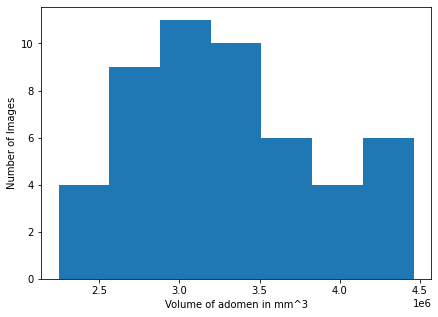

In [156]:
plt.figure(figsize=(7, 5))
plt.hist(image_volumes, bins="auto")
plt.xlabel("Volume of adomen in mm^3")
plt.ylabel("Number of Images");

Images with outlier volumes

In [159]:
outlier_indices = np.where(image_volumes > 4e6)
outlier_indices

(array([ 6, 14, 18, 27, 43, 44, 47]),)

In [160]:
image_sizes[outlier_indices]

array([[407, 407, 262],
       [370, 370, 210],
       [386, 386, 490],
       [500, 500, 222],
       [485, 485, 207],
       [500, 500, 282],
       [399, 399, 237]], dtype=uint16)

Image with maximum volume

In [161]:
max_index = image_volumes.argmax()
max_index

18

In [162]:
image_sizes[max_index]

array([386, 386, 490], dtype=uint16)

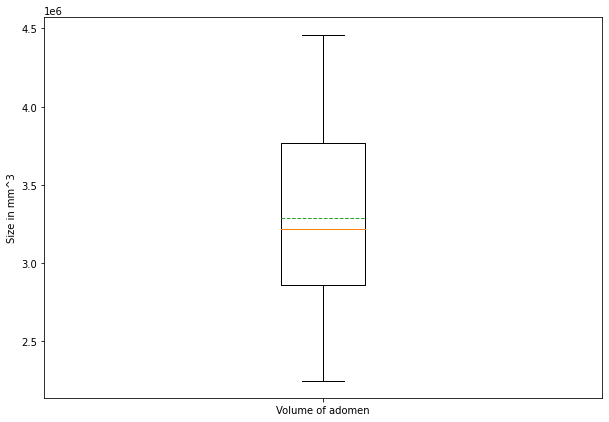

In [163]:
plt.figure(figsize=(10, 7))
plt.boxplot(image_volumes, showmeans=True, meanline=True, labels=("Volume of adomen",))
plt.ylabel("Size in mm^3");

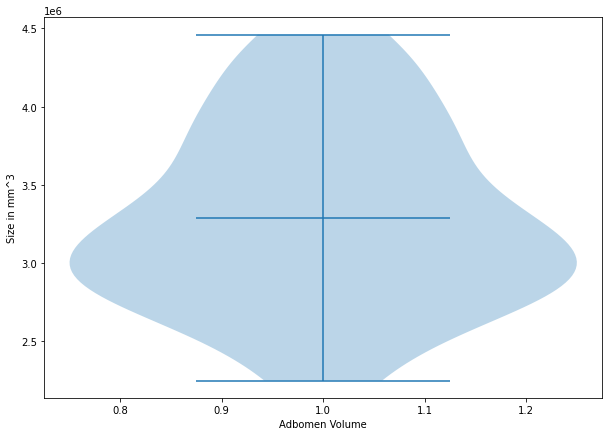

In [164]:
plt.figure(figsize=(10, 7))
plt.violinplot(image_volumes, showmeans=True)
plt.xlabel("Adbomen Volume")
plt.ylabel("Size in mm^3");

Calculate max size in each dimension

In [165]:
max_shape = image_sizes.max(axis=0)
max_shape

array([500, 500, 490], dtype=uint16)

In [166]:
max_shape.prod()

122500000

In [167]:
image_volumes[max_index]

4461026.5

In [168]:
image_sizes.min(axis=0)

array([330, 330, 177], dtype=uint16)

Proportion of each axis

In [54]:
image_size_prop = (image_sizes.T / image_sizes.sum(axis=1)).T

In [55]:
assert (
    image_size_prop.sum() == image_size_prop.shape[0]
), "The proportion is not properly normalized"


AssertionError: The proportion is not properly normalized

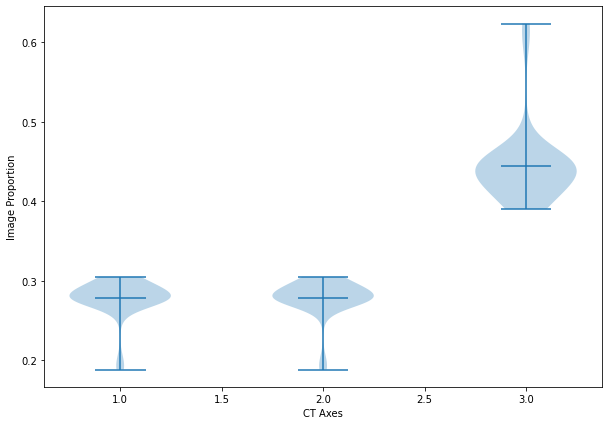

In [56]:
plt.figure(figsize=(10, 7))
plt.violinplot(image_size_prop, showmeans=True)
plt.ylabel("Image Proportion")
plt.xlabel("CT Axes");

# Evaluate the performance of minimum abdomen clipper

In [9]:
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    HistogramNormalized,
    KeepLargestConnectedComponent,
    LoadImaged,
    Orientationd,
    ToTensord,
)
from custom_transforms import CustomResize, CustomResized
from saver import NiftiSaver
from monai.inferers import SlidingWindowInferer
from torch.nn import functional as F
import gc




In [12]:
transforms = Compose(
        (
            LoadImaged(reader="NibabelReader", keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            CustomResized(keys=["image", "label"], roi_size=intermediate_roi_size),
            Orientationd(keys=["image", "label"], axcodes="RAI"),
            HistogramNormalized(keys="image", min=-1, max=1),
            ToTensord(keys=["image", "label"]),
        )
    )

dataset = Dataset(data_dicts, transforms)

saver = NiftiSaver(
    output_dir,
    output_dtype=np.uint8,
    dtype=np.float32,
    mode="nearest",
    padding_mode="zeros",
    separate_folder=False,
    channel_dim=0,
    print_log=True,  # make false for docker
)

device = torch.device("cpu" if gpu_index < 0 else f"cuda:{gpu_index}")

coarse_sliding_inferer = SlidingWindowInferer(
    coarse_roi_size,
    sw_batch_size,
    sw_overlap,
    mode="gaussian",
    cache_roi_weight_map=True,
)

resize_fine = CustomResize(roi_size=fine_roi_size, image_only=True)

keep_connected_component_coarse = KeepLargestConnectedComponent(
            independent=False,
            connectivity=None,
        )

dl = DataLoader(
    dataset,
    batch_size=1,  # Because the images do not align and are not cropped
    num_workers=num_workers,
)

coarse_model = torch.jit.optimize_for_inference(
    torch.jit.load(coarse_ckpt_path, map_location=device)
)

def get_label_volume(arr, pix_dim):
    arr = np.count_nonzero(arr)
    return arr * pix_dim[0] * pix_dim[1] * pix_dim[2]

spatial_size = 3
label_vol_orig = np.empty((len(dl)), dtype=np.float32)
label_vol_cropped = np.empty((len(dl)), dtype=np.float32)
label_vol_resized = np.empty((len(dl)), dtype=np.float32)


In [13]:
with torch.inference_mode():
    for i, batch in enumerate(dl):
        filename = (
            batch["image_meta_dict"]["filename_or_obj"][0]
            .split("/")[-1]
            .split(".")[0]
        )
        print(filename)
        meta_data = {k: v[0] for k, v in batch["image_meta_dict"].items()}
        pixdim = np.abs(np.diag(meta_data['affine'])[:-1])

        image = batch["image"].to(device)
        label = batch.get("label")
        label_vol_orig[i] = get_label_volume(label.cpu().numpy(), pixdim)
        coarse_image = F.interpolate(
            input=image,
            scale_factor=inverse_coarse_scale,
            mode="trilinear",
            recompute_scale_factor=True,
        )

        coarse_output: np.ndarray = (
            (coarse_sliding_inferer(coarse_image, coarse_model) >= 0.5)
            .squeeze(0)
            .cpu()
            .numpy()
        )

        # final_output = torch.zeros(image.shape[1:], dtype=int, device=device)

        if coarse_output.any():
            coarse_output = keep_connected_component_coarse(coarse_output)
            x_indices, y_indices, z_indices = np.where(coarse_output.squeeze(0))

            # Multiplying less scale rather than all the indices
            x1 = int(x_indices.min() * coarse_scale[0])
            x2 = math.ceil(x_indices.max() * coarse_scale[0])
            y1 = int(y_indices.min() * coarse_scale[1])
            y2 = math.ceil(y_indices.max() * coarse_scale[1])
            z1 = int(z_indices.min() * coarse_scale[2])
            z2 = math.ceil(z_indices.max() * coarse_scale[2])
            cropped_label = label[0, :, x1 : x2 + 1, y1 : y2 + 1, z1 : z2 + 1]
            cropped_image = image[0, :, x1 : x2 + 1, y1 : y2 + 1, z1 : z2 + 1]

            label_vol_cropped[i] = get_label_volume(cropped_label, pixdim)
            save_nifti_from_array(cropped_image,"/home/safal/abdomen_intermediate/cropped", f"{filename}_cropped")
            x1, y1, z1, x2, y2, z2 = get_min_sized_abdomen(
                orig_size_pix=image.shape[-3:],
                img_pix_dim=batch["image_meta_dict"]["pixdim"][0][1:4].numpy(),
                boxes_pix=torch.tensor([x1, y1, z1, x2, y2, z2]),
            )
            cropped_label = label[0, :, x1 : x2 + 1, y1 : y2 + 1, z1 : z2 + 1]
            cropped_image = image[0, :, x1 : x2 + 1, y1 : y2 + 1, z1 : z2 + 1]
            label_vol_resized[i]= get_label_volume(cropped_label, pixdim)
            save_nifti_from_array(cropped_image, "/home/safal/abdomen_intermediate/resized", f"{filename}_resized")


        # Run garbage collector if RAM is OOM
        # Reduced max GPU usage from 5G to 4G
        gc.collect()
        if gpu_index >= 0:
            torch.cuda.empty_cache()

FLARE22_Tr_0001_0000
[0.644531 0.644531 2.5     ] Old box tensor([ 22,  56,   0, 238, 220, 126])
New box:  12 45 0 238 234 127
FLARE22_Tr_0002_0000
[0.742188 0.742188 2.5     ] Old box tensor([ 24,  42,   0, 236, 198, 126])
New box:  8 20 0 236 204 127
FLARE22_Tr_0003_0000
[0.767578 0.767578 2.5     ] Old box tensor([ 36,  60,   0, 222, 198, 126])
New box:  10 30 0 222 210 127
FLARE22_Tr_0004_0000
[0.732422 0.732422 2.5     ] Old box tensor([ 26,  66,   0, 230, 206, 126])
New box:  9 39 0 230 221 127
FLARE22_Tr_0005_0000
[0.773438 0.773438 2.5     ] Old box tensor([ 30,  62,   0, 228, 212, 126])
New box:  8 23 0 227 217 127
FLARE22_Tr_0006_0000
[0.863281 0.863281 2.5     ] Old box tensor([ 54,  64,   0, 218, 186, 126])
New box:  8 21 0 217 197 127
FLARE22_Tr_0007_0000
[0.794922 0.794922 2.5     ] Old box tensor([ 32,  64,   0, 236, 204, 126])
New box:  8 25 0 236 212 127
FLARE22_Tr_0008_0000
[0.78125 0.78125 2.5    ] Old box tensor([ 26,  52,   0, 236, 206, 126])
New box:  7 17 0 236 2

In [14]:
label_vol_cropped

array([3049894.5, 3752593.5, 2933874.8, 2899482. , 2905122.2, 3360759.2,
       4140360.2, 3630109.8, 3034636.2, 3217667.5, 3092598.5, 3251580.2,
       2944925. , 2949902. , 4203558.5, 2697272.5, 3869773.8, 3794485.5,
       4461024. , 3826117.2, 2844351.2, 3267990. , 2760891.8, 3440384.2,
       2422142.2, 2266196.5, 3468729.5, 4205068.5, 2813337.8, 2824215.8,
       3267282. , 3063072.8, 2986506. , 2780527.2, 3588522. , 2469687.2,
       3363454. , 3869925. , 3774142. , 3070051. , 2743937.5, 3231147. ,
       2719835.2, 4193547.8, 4384035.5, 2242253.8, 3216710.2, 4422293. ,
       2677739.2, 3899673.8], dtype=float32)

In [15]:
label_vol_resized

array([3049894.5, 3753169.2, 2933874.8, 2900707.2, 2906298.2, 3360992.2,
       4140360.2, 3630652.8, 3036184. , 3218217.5, 3092598.5, 3252472.5,
       2944925. , 2955348. , 4209779. , 2697272.5, 3869773.8, 3796860.8,
       4461024. , 3827120.5, 2844351.2, 3267990. , 2760891.8, 3441430.2,
       2422576.2, 2266196.5, 3468729.5, 4205937. , 2814069.8, 2825306.5,
       3267976.8, 3064094.8, 2986728.5, 2781149. , 3589726. , 2471554.8,
       3364017.2, 3870839.5, 3774142. , 3070051. , 2747815.2, 3232401. ,
       2719835.2, 4196433.5, 4385222.5, 2247099. , 3216710.2, 4424051. ,
       2678221.2, 3899673.8], dtype=float32)

In [16]:
difference = label_vol_resized - label_vol_cropped

In [17]:
difference

array([   0.  ,  575.75,    0.  , 1225.25, 1176.  ,  233.  ,    0.  ,
        543.  , 1547.75,  550.  ,    0.  ,  892.25,    0.  , 5446.  ,
       6220.5 ,    0.  ,    0.  , 2375.25,    0.  , 1003.25,    0.  ,
          0.  ,    0.  , 1046.  ,  434.  ,    0.  ,    0.  ,  868.5 ,
        732.  , 1090.75,  694.75, 1022.  ,  222.5 ,  621.75, 1204.  ,
       1867.5 ,  563.25,  914.5 ,    0.  ,    0.  , 3877.75, 1254.  ,
          0.  , 2885.75, 1187.  , 4845.25,    0.  , 1758.  ,  482.  ,
          0.  ], dtype=float32)

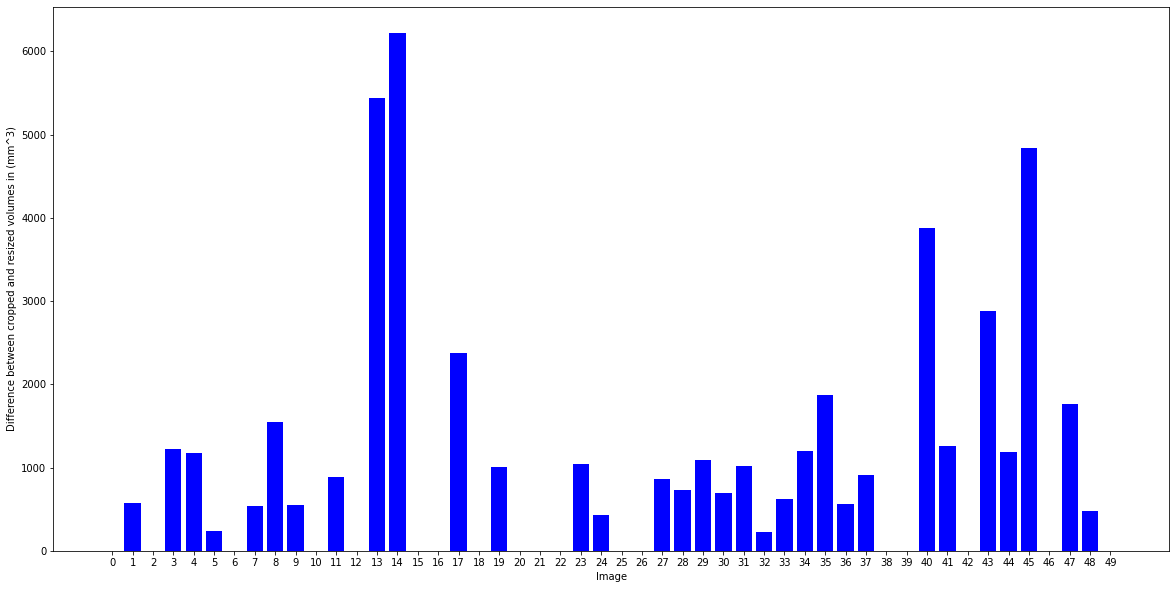

In [18]:
plt.figure(figsize=(20, 10))

plt.bar(range(len(label_vol_cropped)), difference, color="blue", label="Difference")
plt.ylabel("Difference between cropped and resized volumes in (mm^3)")
plt.xlabel("Image")
plt.xticks(range(len(label_vol_cropped)))
plt.show()